## 2019 EcoFOCI Dyson Cruises

ERDAP with erddapy example for PMEL tools

***requires python >3.6*** 

### connecting and basic information

In [51]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only Dyson Related CTD files

In [52]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='ctd AND dyson'))

In [53]:
dysondata = df['Dataset ID'].values
print(dysondata)

['CTD_dy1805_preliminary' 'CTD_dy1904_preliminary'
 'CTD_dy1807l1_preliminary' 'CTD_dy1807l3_preliminary'
 'CTD_dy1905_preliminary' 'CTD_dy1807l2_preliminary'
 'CTD_dy1906l1_preliminary']


shiptrack datasets are trajectory data, CTD datasets are profile data

In [54]:
variables = [e.get_var_by_attr(dataset_id=data, standard_name=lambda v: v is not None) for data in dysondata]


In [55]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv'
          )

constraints = {
    'time>=': '2019-01-01T00:00:00Z',
    'time<=': '2020-01-01T00:00:00Z',
    'latitude>=': 45,
    'latitude<=': 90,
    'longitude>=': -180,
    'longitude<=': 0
}

variables = [
    'pressure',
    'T_28',
    'Fch_906',
    'O_65',
    'Tr_904',
    'T2_35',
    'CTDOXY_4221',
    'OST_62',
    'latitude',
    'S_41',
    'time',
    'longitude',
    'CTDOST_4220',
    'S_42'
]

In [56]:
variable_dic={}

for index,row in df.iterrows():
    info_url = e.get_info_url(dataset_id=row['Dataset ID'], response='csv')
    info = pd.read_csv(info_url)

    #print(info.head())
    print('Variables in {}:'.format(row['Dataset ID']))
    print(','.join(info.loc[info['Row Type'] == 'variable', 'Variable Name']))

    variable_dic.update({row['Dataset ID']:list(info.loc[info['Row Type'] == 'variable', 'Variable Name'])})
    

Variables in CTD_dy1805_preliminary:
station_id,latitude,longitude,time,pressure,S_42,S_41,Fch_906,T_28,T2_35,O_65,CTDOXY_4221,OST_62,CTDOST_4220,Tr_904
Variables in CTD_dy1904_preliminary:
station_id,latitude,longitude,time,pressure,S_42,S_41,Fch_906,T_28,T2_35,O_65,CTDOXY_4221,OST_62,CTDOST_4220,Tr_904
Variables in CTD_dy1807l1_preliminary:
station_id,latitude,longitude,time,pressure,S_42,S_41,Fch_906,T_28,T2_35,O_65,CTDOXY_4221,OST_62,CTDOST_4220,Tr_904
Variables in CTD_dy1807l3_preliminary:
station_id,latitude,longitude,time,pressure,S_42,S_41,Fch_906,T_28,T2_35,O_65,CTDOXY_4221,OST_62,CTDOST_4220,Tr_904
Variables in CTD_dy1905_preliminary:
station_id,latitude,longitude,time,pressure,S_42,S_41,Fch_906,T_28,T2_35,O_65,CTDOXY_4221,OST_62,CTDOST_4220,Tr_904
Variables in CTD_dy1807l2_preliminary:
station_id,latitude,longitude,time,pressure,S_42,S_41,Fch_906,T_28,T2_35,O_65,CTDOXY_4221,OST_62,CTDOST_4220,Tr_904
Variables in CTD_dy1906l1_preliminary:
station_id,latitude,longitude,time,pr

In [57]:
from requests.exceptions import HTTPError

dfs = {}
for index,row in df.iterrows():
    print(row['Dataset ID'])
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
        )
        e.response='csv'
        e.dataset_id=row['Dataset ID']
        e.constraints=constraints

    except HTTPError:
        print('Failed to generate url {}'.format(row['Dataset ID']))
        continue
        
    try:
        dfs.update({row['Dataset ID']: e.to_pandas(
                            index_col='time (UTC)',
                            parse_dates=True,
                            )})
    except HTTPError:
        print(f"No Valid Data in {row['Dataset ID']}")
        continue
    

CTD_dy1805_preliminary
No Valid Data in CTD_dy1805_preliminary
CTD_dy1904_preliminary
CTD_dy1807l1_preliminary
No Valid Data in CTD_dy1807l1_preliminary
CTD_dy1807l3_preliminary
No Valid Data in CTD_dy1807l3_preliminary
CTD_dy1905_preliminary
CTD_dy1807l2_preliminary
No Valid Data in CTD_dy1807l2_preliminary
CTD_dy1906l1_preliminary


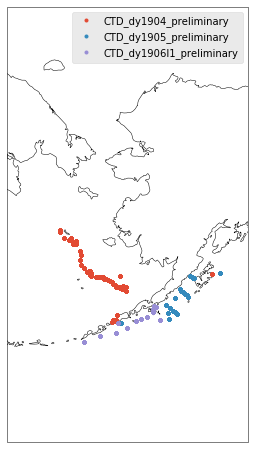

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5

extent = [-176, -150, 45, 75]

fig,ax = make_map(projection=projection)

for key,value in enumerate(dfs):
    ax.plot(dfs[value]['longitude (degrees_east)'], dfs[value]['latitude (degrees_north)'], '.', label=value, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

In [59]:
import seawater as sw

def plot_salvtemp(salt, temp, press, srange=[28,34], trange=[-2,15], ptitle=""): 
    plt.style.use('ggplot')
    
    # Figure out boudaries (mins and maxs)
    smin = srange[0]
    smax = srange[1]
    tmin = trange[0]
    tmax = trange[1]

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))
    
    #print 'ydim: ' + str(ydim) + ' xdim: ' + str(xdim) + ' \n'
    if (xdim > 10000) or (ydim > 10000): 
        print('To many dimensions for grid in {cruise} {cast} file. Likely  missing data \n'.format(cruise=cruise,cast=cast))
        return
 
    # Create empty grid of zeros
    dens = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim-1,ydim)+tmin
    si = np.linspace(0,xdim-1,xdim)*0.1+smin
 
    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            dens[j,i]=sw.dens0(si[i],ti[j])
 
    # Substract 1000 to convert to sigma-t
    dens = dens - 1000
 
    # Plot data ***********************************************
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    CS = plt.contour(si,ti,dens, linestyles='dashed', colors='k')
    plt.clabel(CS, fontsize=12, inline=1, fmt='%1.1f') # Label every second level
 
    ts = ax1.scatter(salt,temp, c=press, cmap='gray', s=10)
    plt.colorbar(ts )
    plt.ylim(tmin,tmax)
    plt.xlim(smin,smax)
 
    ax1.set_xlabel('Salinity (PSU)')
    ax1.set_ylabel('Temperature (C)')

    
    t = fig.suptitle(ptitle, fontsize=12, fontweight='bold')
    t.set_y(1.08)
    return fig  

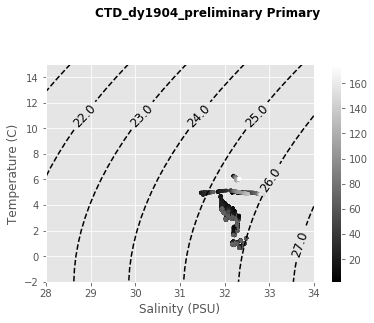

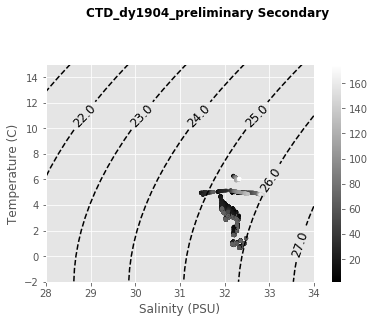

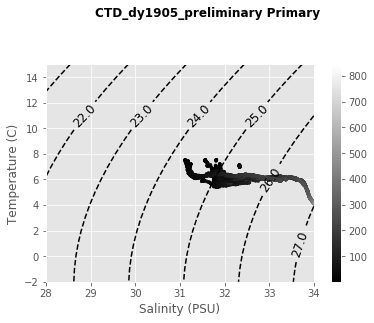

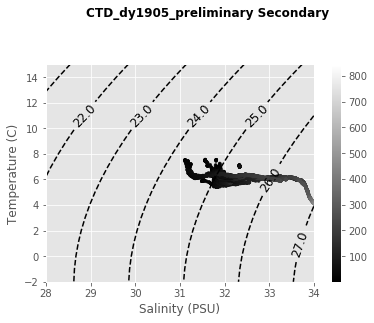

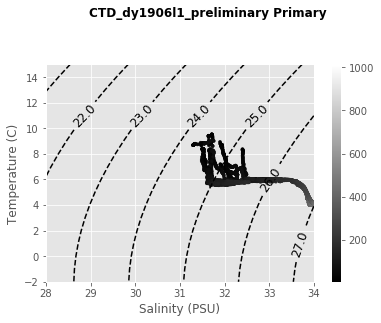

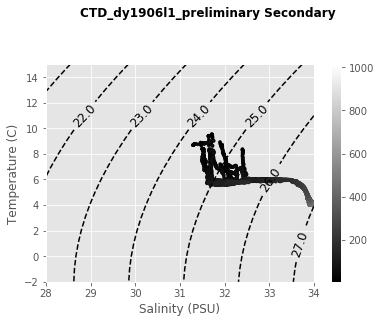

In [60]:
for key,value in enumerate(dfs):
    plot_salvtemp(dfs[value]['S_41 (PSU)'],dfs[value]['T_28 (C)'],dfs[value]['pressure'],ptitle=f'{value} Primary')
    plot_salvtemp(dfs[value]['S_42 (PSU)'],dfs[value]['T2_35 (C)'],dfs[value]['pressure'],ptitle=f'{value} Secondary')